title:'submission test for intern at minodes'
author:'muhammad'@github.com/waheeduddin
date: 19/06/2018

## work division
In the beginning are some helping functions that get used over and over again. the helper functions take six cells and real work follows after them. <br>
    cell[1] = imports <br>
    cell[2] = graph and drawing related functions <br>
    cell[3] = Machine Learning models made easy to use <br>
    cell[4] = a grid search for parameter tuning of ML models <br>
    cell[5] = functions implementing conditions for feature engineering purposes <br>
    cell[6] = a data preparation function that prepares data for either the training set or testing set <br>
    
The helper functions are commented for better understanding.

In [39]:
import sys
import pandas as  pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
#import numpy as np
#from scipy.stats import norm
#from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing
from scipy import stats
%matplotlib inline
import random
import datetime
from sklearn import cluster
import calendar
import numbers
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.ensemble import RandomForestRegressor
from sklearn import svm
import xgboost as xgb
import pickle


In [40]:
def getXticks(tempSeries,axis=0):
    ##A function that helps in labeling and sizing the x-axis of a graph properly
    if axis == 0:#to set the xticks of the multiple plots that will be draw in EDA part
        myxLabels = tempSeries.index.tolist()
        myxLabels.insert(0, ' ')   #basically you need an empty space to give spaings at the ends of your graph i.e. insert ...
        myxLabels.append(' ')      #and append
    else:
        myxLabels = tempSeries.columns.tolist()
        myxLabels.insert(0, ' ')   #basically you need an empty space to give spaings at the ends of your graph i.e. insert ...
        myxLabels.append(' ')      #and append
    return myxLabels

def seriesPlots(tempSeries  ,_title = "", _rot = 15,_xlabel = "",_ylabel = ""):   #one function to plot a pandas.series
    plt.figure()
    axis = plt.gca()
    ax1 = tempSeries.plot(legend=True, ax=axis, marker='o', rot=_rot, figsize=(20, 12), title=_title)
    if(isinstance(tempSeries.index.tolist()[0],numbers.Number)): #the value of xlim are tricky to handle....
        minPoint = int(min(tempSeries.index.tolist())) - 1  #when they are int or float, we want the limits to be the min...
        maxPoint = int(max(tempSeries.index.tolist())) + 1  #max
    else:
        minPoint = -1                             #else an index like array from -1 to lenght of unique values works fine!!!
        maxPoint = len(tempSeries.index.tolist())
    ax1.set_xticks(range(minPoint, maxPoint + 1, 1))
    ax1.set_xticklabels(getXticks(tempSeries))
    ax1.set_ylabel(_ylabel)  
    ax1.set_xlabel(_xlabel)  
    plt.show()
    
def myPlotter(_pred , _target , _startPoint = 1 , _endPoint = 500):  #A standard one graph two lines plot. how many values to be plotted from the predicted and target variables
    ##A function to plot two series together based on starting and ending index
    #_pred: the values that are predicted.
    #_trget: the real values
    xAxisValues = range(_startPoint,_endPoint,1)
    plt.figure(figsize=(16,10))
    plt.plot(xAxisValues, _pred.ravel()[xAxisValues], color='red')
    plt.plot(xAxisValues, _target.ravel()[xAxisValues], color='green')
    plt.legend(['predictions', 'trueValues'], loc='upper left')
    plt.ylabel('continous values')
    plt.xlabel('index of observation')
    
    plt.show()
    return


In [41]:
def do_svm(X_train, X_test, y_train, y_test):
    ##SVM used as to solve a regression problem
    clf = svm.SVR(C=1.0, epsilon=0.2)  #SVR model initialized with radial basis kernel
    clf.fit(X_train, y_train)
    preds = clf.predict(X_test)
    y_test_corrected = y_test.loc[y_test.values != 0].values
    preds_corrected = preds[y_test.values != 0]
    rmspe = np.sqrt(np.mean( (y_test_corrected - preds_corrected))**2 )##error formula from kaggle
    print('rmspe in SVM:' , rmspe)
    return score , 'SVM' , clf #to sotre the model back

def do_randomForest(X_train, X_test, y_train, y_test):
    rf = RandomForestRegressor(n_estimators=300)#As i have more than 18 features (depending on how many categories are there), 
                                                #I probably need more depth per tree as well 
    rf.fit(X_train, y_train)
    preds = rf.predict(X_test)
    y_test_corrected = y_test.loc[y_test.values != 0].values
    preds_corrected = preds[y_test.values != 0]
    rmspe = np.sqrt(np.mean( (y_test_corrected - preds_corrected))**2 )
    print('rmspe in Random Forest:' , rmspe)
    return rmspe , 'RandomForest' , rf

def do_xgb(X_train, X_test, y_train, y_test):
    params = {"objective": "reg:linear",
          "eta": 0.3,
          "max_depth": 5,
          "subsample": 0.7,
          "colsample_bytree": 0.7,
          "silent": 1
          }    
    num_trees = 300#xgb is fast so the max_depth is larger here than the default in randomForestRegressor function
    dtrain = xgb.DMatrix(X_train, np.log(y_train.values + 1))
    dvalid = xgb.DMatrix(X_test, np.log(y_test.values + 1))
    watchlist = [(dvalid, 'eval'), (dtrain, 'train')]
    gbm = xgb.train(params, dtrain, num_trees, evals=watchlist, early_stopping_rounds=50, verbose_eval=True)#feval=rmspe_xg

    preds = gbm.predict(xgb.DMatrix(X_test))
    rmspe = np.sqrt(np.mean( (y_test.values - (np.exp(preds)-1))**2 ))
    print('rmspe  in xgBoost is : ', rmspe)
    return rmspe, 'xgBoost' , gbm

In [42]:
def do_gridSearch(X_train, X_test, y_train, y_test,_model):
    params_rf = {'max_depth':(4,6,8,10,12,14,16,20),
         'n_estimators':(4,8,16,24,48,72,96,128),
         'min_samples_split':(2,4,6,8,10)}#only parameteres for random forest model.
    grid = model_selection.RandomizedSearchCV(estimator=_model,param_distributions=params_rf,cv=10) 
    grid.fit(X_train, y_train)
    return grid.best_params_,grid.best_score_

In [43]:
def saveMyModel(_fileName,_model,_modelType):
    #much important pickling 
    filename = _fileName+'_'+_modelType+'.sav'
    pickle.dump(_model, open(filename, 'wb'))

In [44]:
def competitionOpeningDate(dataRow):
    ##returns the date that is the 1st day of the month and year when competition to a store was opened
    #returns an empty string if competition data is not observed
    #the date is helpful to see the effect of competition by date
    if(not(np.isnan(dataRow['CompetitionOpenSinceMonth']))): 
        if(not(np.isnan(dataRow['CompetitionOpenSinceYear']))):
            return datetime.datetime(year=int(dataRow['CompetitionOpenSinceYear']), month=int(dataRow['CompetitionOpenSinceMonth']), day=1)
        else:
            return ''
    else:
        return ''

def promo2Worker(dataRow):
    ##checks of for the given day of sale (date), is the promo2 for the store active.
    #works on the assumption that every year Promo2 is only active for the months in field 'promoInterval'
    
    if dataRow['Promo2'] == 0:
        return 'No' # No promo2
    currentWeek = datetime.datetime.strptime(str(dataRow['Date']),'%Y-%m-%d').strftime('%W')#need currentWeek
    currentYear = datetime.datetime.strptime(str(dataRow['Date']),'%Y-%m-%d').strftime('%Y')# and currentYear
    currentMonthStr =  datetime.datetime.strptime(str(dataRow['Date']),'%Y-%m-%d').strftime('%b')#and name of month
    #the above three variables are compared with promo2SinceWeek,promo2SinceYear,promoInterval
    if ((float(currentWeek) >= dataRow['Promo2SinceWeek']) & (float(currentYear) >= dataRow['Promo2SinceYear'])):
        if (currentMonthStr in dataRow['PromoInterval']):
            return 'Yes'
        else: 
            return 'No'
    else:
        return 'Yes'
    
def lumpAssortmentStoreType(dataRow):
    ##from EDA it was seen that the sales and customers for storeType & Assortment == 'b' stands out
    if  (dataRow['Assortment'] == 'b')  & (dataRow['StoreType'] == 'b'):#just a chekc to catch stores of this type
        return 'yes'
    else :
        return 'no'
def correctStateHolidays(value):
    if  ((str(value) == '0')  | (str(value) == 'o') |(str(value) == 'O') ):#just a chekc to catch stores of this type
        return 'O'
    else :
        return value

## data preperation
the insghts from EDA are already learned, and the data is prepared in this following cell. To see how the EDA is done please check the file in the folder. "detail_EDA.ipynb"

In [45]:
def prepData(fileName,_nrows=None, _dataType='Train'):
    ##The main function that does the feature engineering job
    #nrows: just to quickly work through less than full data
    #_dataType: if _datatype != 'Train' the 'Sales' column is not looked for while returning features
    df_read = pd.read_csv(fileName,nrows=_nrows)#read file
    df_read['MonthYear'] = df_read['Date'].apply(lambda x : (str(x)[:7]))#As the Date is a string '%Y-%m-%d' format, first 7 indices are 'Year-Month'
    df_read['Month'] = df_read['Date'].apply(lambda x : (str(x)[5:7]))#only month
    df_read['Year'] = df_read['Date'].apply(lambda x : (str(x)[:4]))#First four only Year
    df_read['DayOfWeek_str'] = df_read['DayOfWeek'].apply(lambda x : (calendar.day_abbr[x-1]))#the dayOfWeek is stored as a category
    
    df_read['StateHoliday'] = df_read.StateHoliday.apply(lambda x: correctStateHolidays(x))#some values in the data need adjustment
    
    df_read = df_read.drop(df_read['Open'] == 0)##removing these rows for data Quality.check EDA file more info.
    df_store = pd.read_csv('../store.csv') # the store data

    df_store['competitionOpeningFinalDate']= df_store.apply(lambda x: competitionOpeningDate(x) , axis = 1)##calling a helper function to get competion opening date
    df_combined = df_read.merge(df_store, how='left', on='Store')#the left merge

    df_combined['isItPromo2'] = df_combined.apply(lambda x: promo2Worker(x) , axis = 1)##calling a helper function
    df_combined['Date_dateTime'] = df_combined['Date'].apply(lambda x: datetime.datetime.strptime(str(x),'%Y-%m-%d'))#converting string Date to datetime Date. to be used later for comparing timestamps
    df_combined['IsCompetitionNow'] =df_combined.apply((lambda x: 'Yes' if x['Date_dateTime'] >= x['competitionOpeningFinalDate'] else 'No'),axis=1)#returns if the given Date of Sale falls after the competion was open or before
    df_combined['assortment_storeType'] =df_combined.apply((lambda x: lumpAssortmentStoreType(x)),axis=1)#taking out the engineered feature about storeType 'b'

    if (_dataType == 'Train'):
        #these columnNames are the seected features for ML models
        columnNames = ['SchoolHoliday','Promo','Sales','IsCompetitionNow','Open','DayOfWeek_str','assortment_storeType','CompetitionDistance']
    else:
        #sales column is missing for test set
        columnNames = ['SchoolHoliday','Promo','IsCompetitionNow','Open','DayOfWeek_str','assortment_storeType','CompetitionDistance']
    baseLineDf = df_combined.loc[:,columnNames]
    
    #normalizing the numerical features
    for col in ['CompetitionDistance']:
        min_max_scaler = preprocessing.MinMaxScaler()
        null_index = baseLineDf[col].isnull()
        baseLineDf.loc[~null_index, [col]] = min_max_scaler.fit_transform(baseLineDf.loc[~null_index,[col]])
    #converting categorical features to string
    baseLineDf['Promo_str'] =baseLineDf['Promo'].apply(lambda x: 'yes' if x == 1 else 'no')
    baseLineDf['SchoolHoliday_str'] =baseLineDf['SchoolHoliday'].apply(lambda x: 'yes' if x == 1 else 'no')
    baseLineDf['Open_str'] =baseLineDf['Open'].apply(lambda x: 'yes' if x == 1 else 'no')
    #resing the features set because models do not cater for missing data
    baseLineDf = baseLineDf.dropna()
    categorical_subset = baseLineDf[['SchoolHoliday_str','Promo_str','IsCompetitionNow','Open_str','DayOfWeek_str','assortment_storeType']]
    categorical_subset = pd.get_dummies(categorical_subset)
    #seperating the features from labels
    features = pd.concat([baseLineDf['CompetitionDistance'] ,categorical_subset], axis = 1)

    return features , baseLineDf , df_combined #returngin the dataSet with all fields for EDA

In [46]:
df_train_features , df_train_prepared , df_train = prepData('../train.csv')#loading Data and preparing it


c:\users\gebruiker\appdata\local\programs\python\python35\lib\site-packages\IPython\core\interactiveshell.py:2850: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


# EDA


In [47]:

df_train = df_train.drop(df_train['Open'] == 0)#the sales when Open == 0 are zero. so this data will only skew the average and mean calcualation

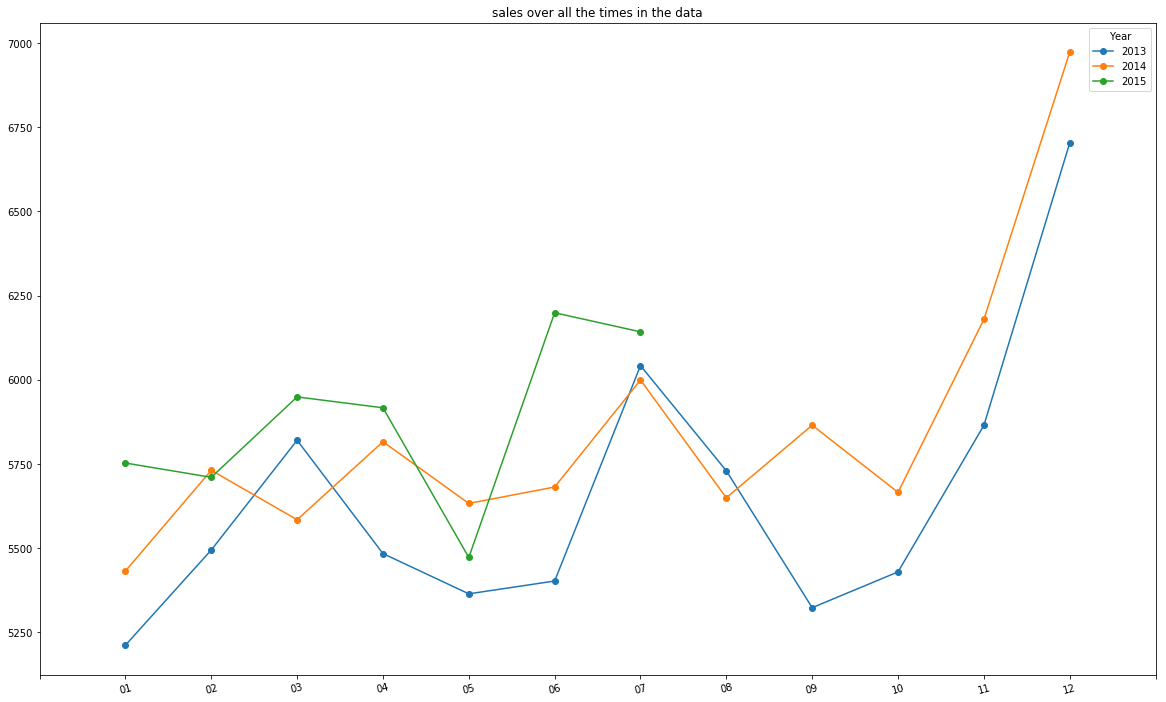

In [48]:
overAllMonthlySales = df_train.groupby(['Month','Year'])["Sales"].mean()
seriesPlots(overAllMonthlySales.unstack(),_title='sales over all the times in the data')

### insight:
the sales increase before vacation seaon like at the end of the year and around summers of evey year

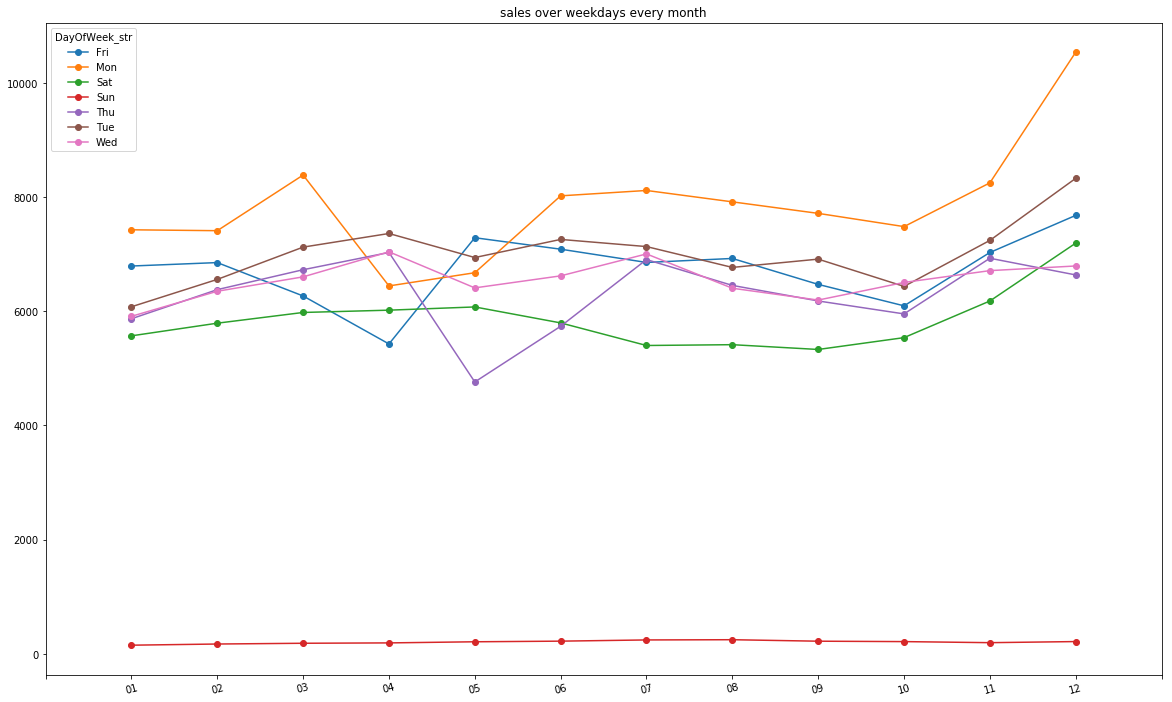

In [49]:
monthlySalesOverWeekdays = df_train.groupby(['Month','DayOfWeek_str'])["Sales"].mean()
seriesPlots(monthlySalesOverWeekdays.unstack(),'sales over weekdays every month')

### insight
The average sales on some days are higher than others while fro sunday is consistently lower. see more in the EDA file

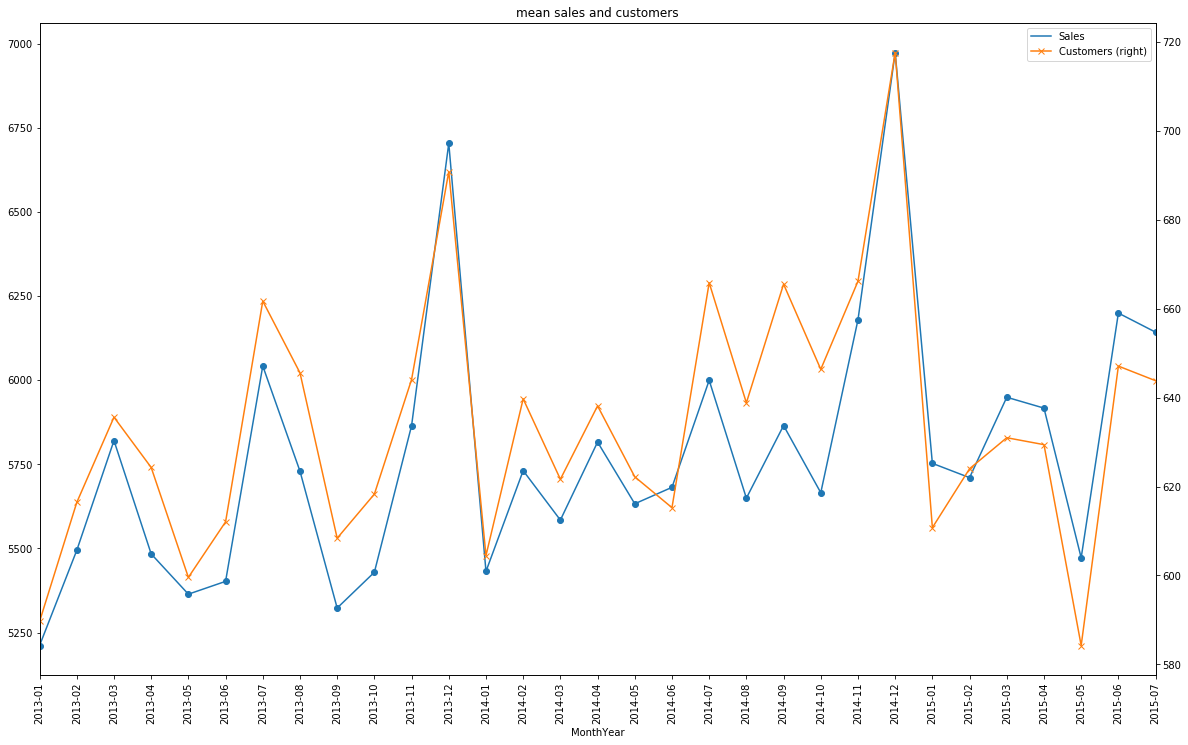

In [50]:
plt.figure()
axis = plt.gca()
overAllMonthlySales = df_train.groupby(['MonthYear'])["Sales"].mean()
ax1 = overAllMonthlySales.plot(legend=True, ax=axis, marker='o', figsize=(20, 12), title='mean sales and customers')
ax1.set_xticks(range(len(overAllMonthlySales)))
ax1.set_xticklabels(overAllMonthlySales.index.tolist(),rotation = 90)
# plot pct change
overAllMonthlyCustomers = df_train.groupby(['MonthYear'])["Customers"].mean()
ax2 = overAllMonthlyCustomers.plot(legend=True, ax=axis,rot = 90, marker='x',secondary_y=True)

### insight
customers and slaes are highly correlated. lets look at per store data to see if its true

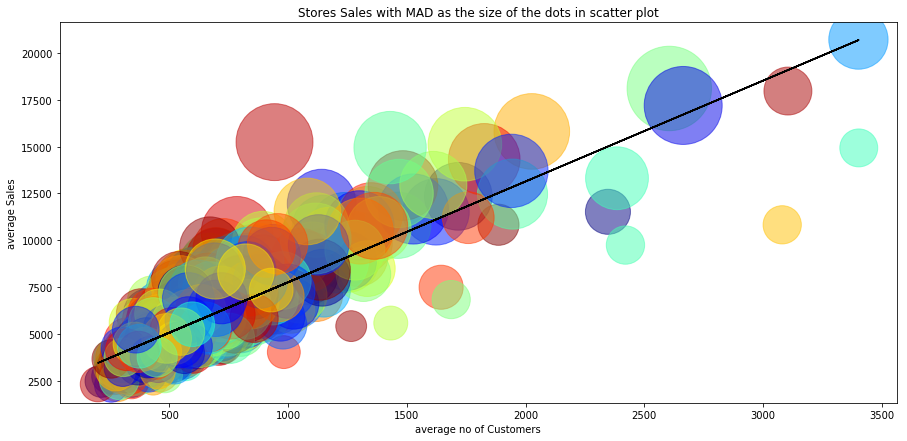

In [51]:
####realte from above with customer graphs
sales_perstore = df_train.groupby('Store')['Sales'].mean()
mad_sales_perstore = df_train.groupby('Store')['Sales'].mad()
cust_perstore = df_train.groupby('Store')["Customers"].mean()
mad_cust_perstore = df_train.groupby('Store')['Customers'].mad()
# sales to customer ratio
sales_cust_ratio = sales_perstore/cust_perstore
mad_sales_cust_ratio = mad_sales_perstore/cust_perstore  # MAD for sales_cust_ratio is ratio between MAD sales and total customers
# plot scatter plot of sales vs customers
fig, (axis1) = plt.subplots(1,1, sharex=True,figsize=(15,7))
colors = np.random.rand(len(sales_perstore))
axis1.scatter(cust_perstore, sales_perstore, s=mad_sales_perstore, c=colors, cmap='jet', alpha=0.5)
axis1.set_xlabel('average no of Customers')
axis1.set_ylabel('average Sales')
axis1.set_title('Stores Sales with MAD as the size of the dots in scatter plot')
# plot a fitted line
linefit = np.poly1d(np.polyfit(cust_perstore, sales_perstore, 1))(cust_perstore);
axis1.plot(cust_perstore, linefit, color = 'k')

### insight
though it is true that for any store if there are more customers they will have more sales, THis information is not good for us as in real life customers data is something we can control. For a ML model, it should rely on calculateable features. below is the correlation between customers and sales

In [52]:
stats.pearsonr(df_train.Customers, df_train.Sales)[0]

0.8947103977140908

### Affect of Promotion
There are more sales in general when there is a promotoion going on. though over the whole span of data, the affect is very small on any given value. see EDA file for details

Average sale when there is NO promotion:  4406.050805160786
Average sale when there is A promotion:  7991.14773910265


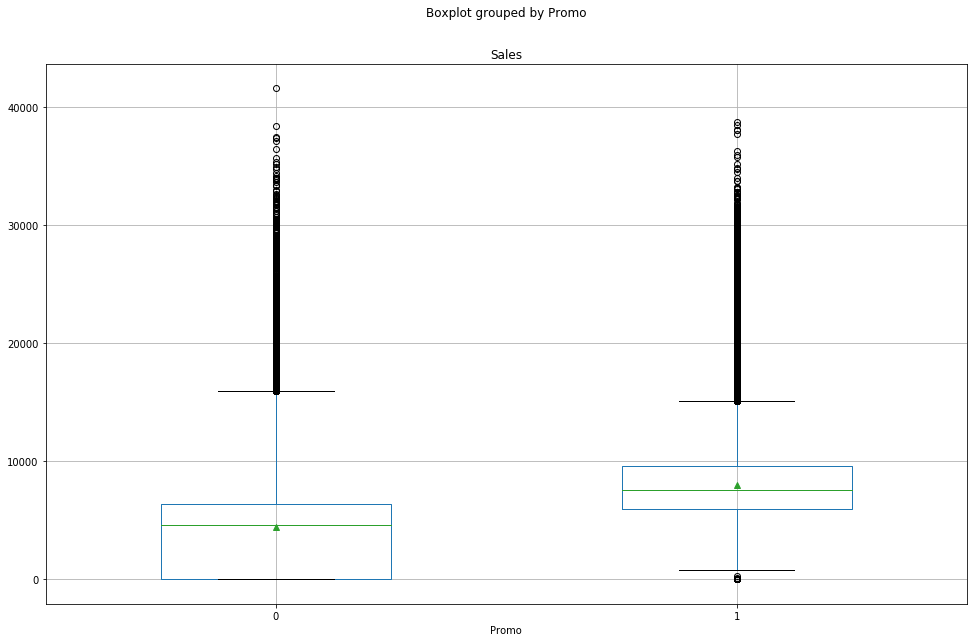

In [53]:
valuesOfMeans = df_train.groupby(['Promo'])["Sales"].mean()
print('Average sale when there is NO promotion: ',valuesOfMeans.values[0])
print('Average sale when there is A promotion: ',valuesOfMeans.values[1])
df_train.boxplot(by='Promo',column='Sales',figsize=(16,10),widths=0.5,showbox=True,showcaps=True,showfliers=True,showmeans=True)

### insight
to see the affect of State Holiday, school holiday, and Promo on a monthly basis over the sales, let us calculate following helpful clusters

In [54]:
mean_sales = df_train.groupby('MonthYear')['Sales'].mean()
pct_mean_change = df_train.groupby('MonthYear')['Sales'].mean().pct_change()
# median customers
mean_cust = df_train.groupby('MonthYear')['Customers'].mean()
pct_mean_custchange = df_train.groupby('MonthYear')['Customers'].mean().pct_change()

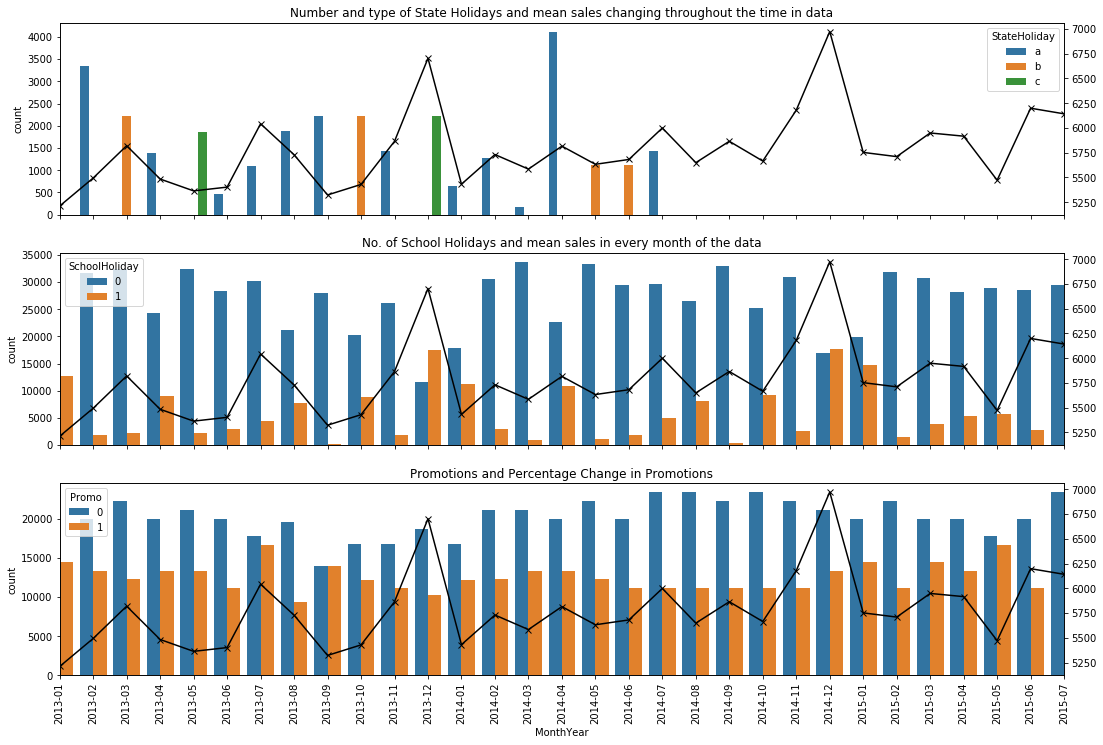

In [55]:
ig, (ax) = plt.subplots(3, 1, sharex=True, figsize=(18,12)) # axis1, axis2, 
ax[0] = sns.countplot(x='MonthYear', hue='StateHoliday', data=df_train[df_train['StateHoliday']!='O'], ax=ax[0])
tmp = ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=90)
mean_sales.plot(ax=ax[0], marker='x', secondary_y=True,color= 'k')
tmp = ax[0].set_title('Number and type of State Holidays and mean sales changing throughout the time in data')
#schoolholiday overlay
ax[1] = sns.countplot(x='MonthYear', hue='SchoolHoliday', data=df_train, ax=ax[1])
mean_sales.plot(ax=ax[1], marker='x', secondary_y=True,color= 'k')
tmp = ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation=90)
tmp = ax[1].set_title('No. of School Holidays and mean sales in every month of the data')
#promotions overlay
#ax5 = sns.countplot(x='MonthYear', hue='Promo', data=df_train[df_train["Promo"]!=0], palette='husl', ax=axis5)
ax[2] = sns.countplot(x='MonthYear', hue='Promo', data=df_train, ax=ax[2])
#subs = train[train['Promo']!=0]
#cntchange = subs.groupby('MonthYear')['Promo'].count().pct_change()
#cntchange.plot(ax=axis5, marker='x', secondary_y=True)
mean_sales.plot(ax=ax[2], marker='x', secondary_y=True,color= 'k')
tmp = ax[2].set_xticklabels(ax[2].get_xticklabels(), rotation=90)
tmp = ax[2].set_title('Promotions and Percentage Change in Promotions')

### insight
the schoolHolidays have a peculiar effect. whenever their are more school holidays in two consecutive months, the sales fall down.
there is too much promotion values all over the place to see an affect. also the statHoliday variable is less likely to affect in a repeated fashion over the sales

### affect of Assortment
there is a prticular assortment type whose sales stands out than the rest of the data. The same is true for the 'storetype' variable. Therefore, a feautre categorising this observations is made. for the affect of 'storeType' on sales, see the detail EDA file.

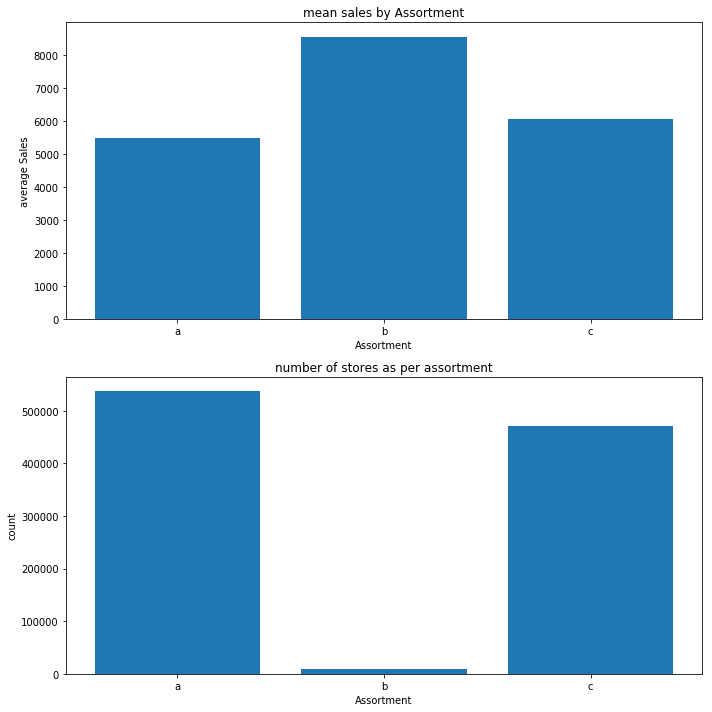

In [56]:
unique_types = len(np.unique(df_train['Assortment'])) 
x = range(unique_types)
xLabels = list(df_train.groupby(by="Assortment").sum().Sales.index)

fig, axes = plt.subplots(2, 1,figsize=(10,10))
y = df_train.groupby("Assortment").Sales.mean()
axes[0].bar(x,y)
axes[0].set_ylabel("average Sales")  
axes[0].set_xlabel("Assortment") 
axes[0].set_xticks(x)
axes[0].set_xticklabels(xLabels)
axes[0].set_title("mean sales by Assortment")

y = df_train.groupby("Assortment").Sales.count()
axes[1].bar(x,y.values)
axes[1].set_ylabel("count")
axes[1].set_xlabel("Assortment")
axes[1].set_xticks(x)
axes[1].set_xticklabels(xLabels)
axes[1].set_title("number of stores as per assortment")

fig.tight_layout()

plt.show()


### Affect of second promotions
second promotions to not help increase or decrease the sale

Average sale when there is NO promotion:  5962.702380463499
Average sale when there is A promotion:  5428.566344571454


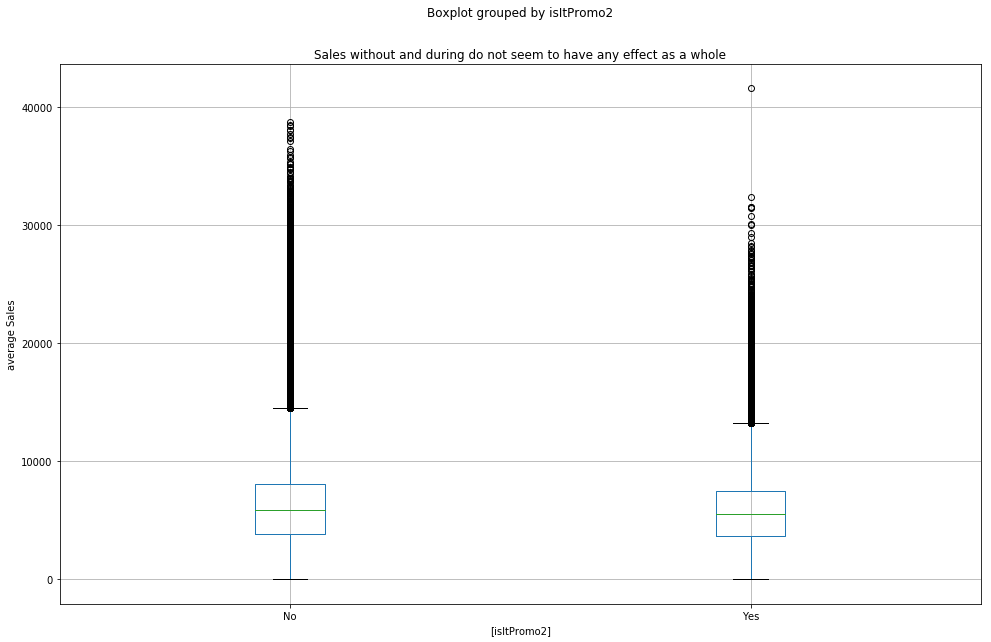

In [57]:
valuesOfMeans = df_train.groupby(['isItPromo2'])["Sales"].mean()
print('Average sale when there is NO promotion: ',valuesOfMeans.values[0])
print('Average sale when there is A promotion: ',valuesOfMeans.values[1])
ax = df_train.boxplot(column='Sales',by=['isItPromo2'],figsize=(16,10))
ax.set_ylabel("average Sales")
ax.set_title('Sales without and during do not seem to have any effect as a whole')

### affect of compeition opening nearby 
This is tricky. The set alone affect of competition opening is not ver clear. Most of the stores do face a challenge. The affect can be studied by looking closely at the values of sales directly before and after the competition opens. that affect is not visible over all the data. Below are the sales for days when the competition was and was not there. One can see that most stores faced competition yet in comtrast the sales of the same stores (color of the balls) when competition was not there does not behave in a predictive way.

In [58]:
#iscompetitonNow
df_withCompetitionDates = df_train[df_train['competitionOpeningFinalDate'].notnull()]
numberOfDaysUnderCompetition = df_withCompetitionDates.groupby(['Store','IsCompetitionNow'])['Date'].count()
salesOfStoresUnderCompetition = df_withCompetitionDates.groupby(['Store','IsCompetitionNow'])["Sales"].mean()
salesOfStoresUnderCompetition = salesOfStoresUnderCompetition.unstack()
numberOfDaysUnderCompetition = numberOfDaysUnderCompetition.unstack()

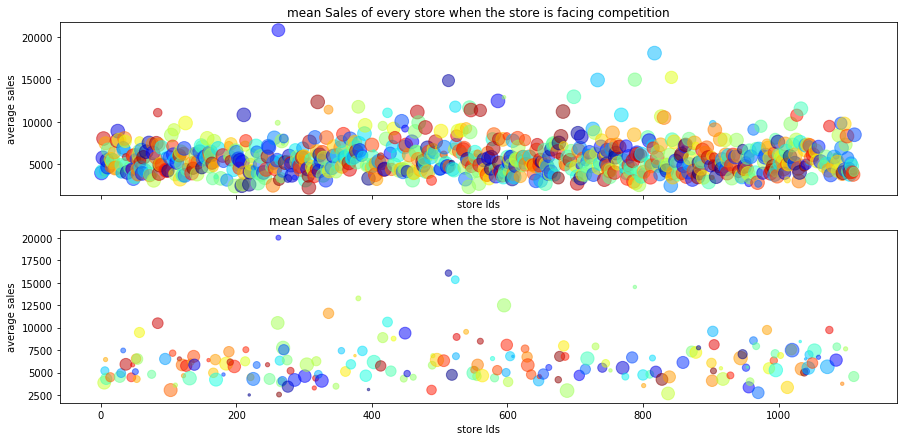

In [59]:
competitionOpenDays = numberOfDaysUnderCompetition['Yes']
competitionClosedDays = numberOfDaysUnderCompetition['No']

compOpenSales = salesOfStoresUnderCompetition['Yes']
compClosedSales = salesOfStoresUnderCompetition['No']

stores_list = list(np.unique( df_withCompetitionDates['Store']))
# plot scatter plot of sales vs customers
fig, (axis) = plt.subplots(2,1, sharex=True,figsize=(15,7))
colors = np.random.rand(len(stores_list))
axis[0].scatter(stores_list, compOpenSales, s=(competitionOpenDays/5), c=colors, cmap='jet', alpha=0.5,)
axis[0].set_xlabel('store Ids')
axis[0].set_ylabel('average sales')
axis[0].set_title("mean Sales of every store when the store is facing competition")

axis[1].scatter(stores_list, compClosedSales, s=(competitionClosedDays/5), c=colors, cmap='jet', alpha=0.5)
axis[1].set_xlabel('store Ids')
axis[1].set_ylabel('average sales')
axis[1].set_title("mean Sales of every store when the store is Not haveing competition")

### affect of competition distance
the competition distance is a right skewed continuous variable and its effects varies over the data. Below the distance is categorized by K-mean clustering in order to maximise the seperation between sales of stores having different categories of competion distance.
note: As the method K-means converges randomly, the clusters fromed are not same for every run of the project. The Competion distance feature is used as a continuous field in the prediction models

c:\users\gebruiker\appdata\local\programs\python\python35\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


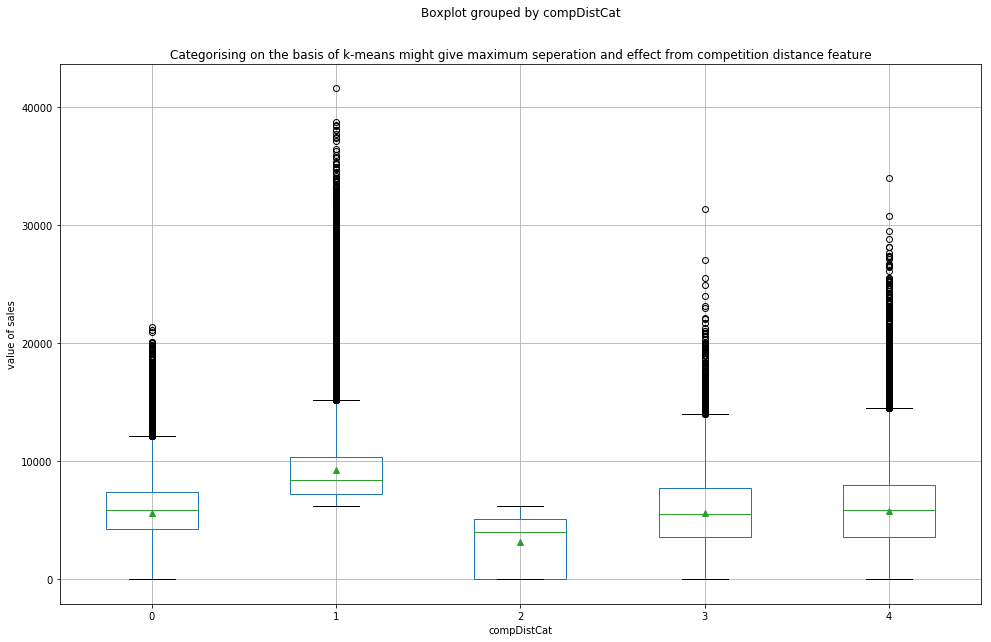

In [60]:
sub_comptData = df_train[df_train['CompetitionDistance'].notnull()]
from sklearn import cluster
k_means = cluster.KMeans(n_clusters=5)
#sub_comptData = sub_comptData[sub_comptData['salesPerCustomer'].notnull()]
model = k_means.fit(sub_comptData[['CompetitionDistance','Sales']]) 
sub_comptData['compDistCat'] = model.labels_
ax = sub_comptData.boxplot(by='compDistCat',column='Sales',figsize=(16,10),widths=0.5,showbox=True,showcaps=True,showfliers=True,showmeans=True)
ax.set_ylabel('value of sales')

ax.set_title('Categorising on the basis of k-means might give maximum seperation and effect from competition distance feature')

Though the assortment and store type do affect the sales but their representation (number of such observations) in the data is too small in comaprison.

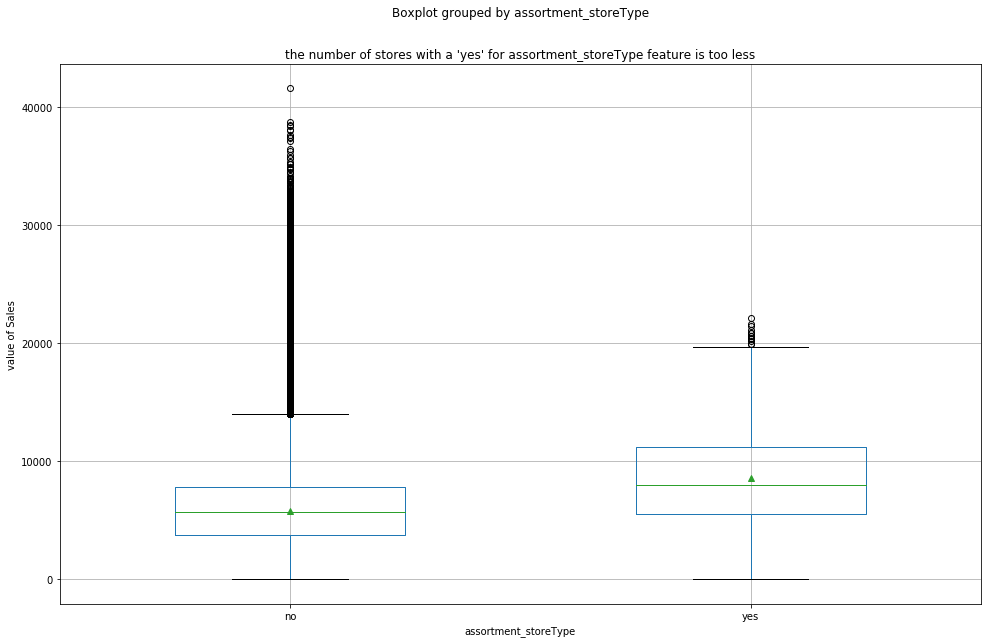

In [61]:
ax = df_train.boxplot(by='assortment_storeType',column='Sales',figsize=(16,10),widths=0.5,showbox=True,showcaps=True,showfliers=True,showmeans=True)
ax.set_ylabel("value of Sales")
ax.set_title('the number of stores with a \'yes\' for assortment_storeType feature is too less')

### final remark on EDA
After observing the data, following features are selected: <br>
 SchoolHoliday: as the number of schoolHolidays on a given month have a trend appering between them and monthly sales <br>
 Promo: more sales when the stores are running promotion <br>
 IsItCompetitionNow: Most stores are facing a competition. but this variable forms a timeseries of its own for each store.<br> 
 Open: the sales are zero if the store is not open. THis variable can remove data quality issues and errors <br>
 dayOfWeek: the sales in days of week vary <br>
 assortment_storeType: the affect of the storetype and assortment anomaly. Maybe it is better if I remove such data altogether. <br>
 CompetitionDistance: as a continous variable.<br>

## Prediction

In [62]:
X_train, X_test, y_train, y_test= train_test_split(df_train_features,df_train_prepared['Sales'], test_size=0.33)##splitting by using sklearn function

In [63]:
trainingScore , modelAlgorithm , model = do_randomForest(X_train, X_test, y_train, y_test)#result of randomForest

rmspe in Random Forest: 4.018013845088807


In [64]:
#saveMyModel('finalTryFullData',model,'RandomForest')

A feature importance graph can be plotted using python utilities to find out the relative importance of features. lets see how the sales performed on prediction

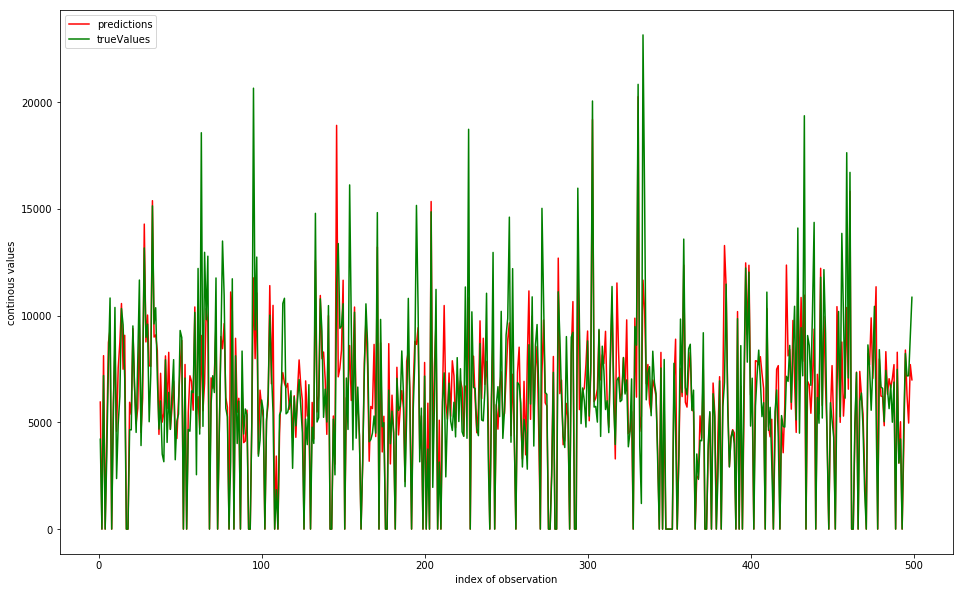

In [65]:
preds = model.predict(X_test)
myPlotter(_pred = preds , _target=y_test.values)

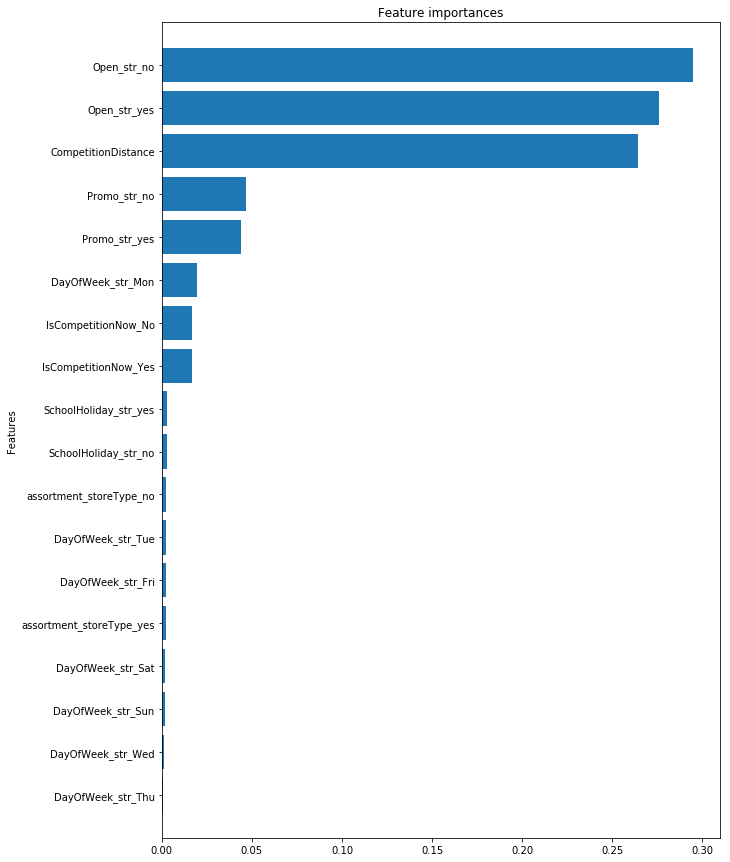

In [67]:
import itertools
#####THIS PEACE OF CODE IS COPIED FROM THE INTERNET
importances = model.feature_importances_
std = np.std([model.feature_importances_ for tree in model.estimators_],
             axis=0)
indices = np.argsort(importances)
palette1 = itertools.cycle(sns.color_palette())
# Store the feature ranking
features_ranked=[]
for f in range(X_train.shape[1]):
    features_ranked.append(X_train.columns[indices[f]])
# Plot the feature importances of the forest

plt.figure(figsize=(10,15))
plt.title("Feature importances")
plt.barh(range(X_train.shape[1]), importances[indices],
            color=[next(palette1)], align="center")
plt.yticks(range(X_train.shape[1]), features_ranked)
plt.ylabel('Features')
plt.ylim([-1, X_train.shape[1]])
plt.show()

In [68]:
saveMyModel('finalTryFullData',model,'RandomForest')

In [69]:
df_test_features , df_test_prepared , df_test= prepData('../test.csv',_dataType='Test')

In [70]:
myFinal_preds = model.predict(df_test_features)

In [71]:
pd.Series(myFinal_preds).to_csv('answer.csv')#the final predictions are saved in a csv